In [2]:
import os
from typing import List
# import biopython package
from Bio import SeqIO

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from torch import optim
from torch.utils.data import DataLoader

from dataset.idr_dataset import IDRDataset, Sequence, collate_fn
from dataset.utils import PadRightTo, parse_target

from utils.common import dump_list2json

import params.filePath as paramF
import params.hyperparams as paramH

import json

from model.utils import plot_auc_and_loss, plot_roc_curve, save_checkpoint, load_checkpoint
from model.train import train, test, predict_one_sequence


# import model
import importlib
model = importlib.import_module(paramH.netName)

# only the encoder part of the mdoel
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

from dataset.embedding import get_PLM_embedding

/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load the model

## plm

In [ ]:
# 1. model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)
plm = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
plm = plm.to(device)
plm = plm.eval()


Using device: cuda


## predictor

In [ ]:
# Instantiate the model
net = model.Net(in_features=paramH.n_features, dropout=paramH.dropout).to(device)

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=paramH.lr)

In [ ]:
net, optimizer, start_epoch, losslogger = load_checkpoint(net, optimizer, paramF.model_pth)

In [ ]:
net.eval()

# 2. sequence

In [7]:
# Q9Y223 Q5ZVE4 O08908
unp_acc = 'A0A024QZB8'
test_seq_pth = os.path.join(paramF.path_uniprot, f'{unp_acc}.fasta')
print(test_seq_pth)
seq = str(SeqIO.read(test_seq_pth, 'fasta').seq)

/home/dimeng/project/idr/data/uniprot/A0A024QZB8.fasta


In [7]:
# seq = "TDERDRVQKKTFTKWVNKHLIKHWRAEAQRHISDLYEDLRDGHNLISLLEVLSGDSLPREKGRMRFHKLQNVQIALDYLRHRQVKLVNIRNDDIADGNPKLTLGLIWTIILHFQISDIQVSGQSEDMTAKEKLLLWSQRMVEGYQGLRCDNFTTSWRDGRLFNAIIHRHKPMLIDMNKVYRQTNLENLDQAFSVAERDLGVTRLLDPEDVDVPQPDEKSIITYVSSLYDAMPRVPGAQ"

# 3. embedding

## 3.1. embedding + prediction

In [9]:
seq = ' '.join(seq)
seq_embedded = get_PLM_embedding([seq], plm, tokenizer)
data = torch.tensor(np.array(seq_embedded)[0].T).unsqueeze(0)
pred = net(data).tolist()[0]

In [10]:
data.shape

torch.Size([1, 1024, 438])

## 3.2. (ignore!!!!)load embedded data --> prediction

In [28]:
# Load the data
train_data = pd.read_json(os.path.join(train_json_path), orient='records', dtype=False)
test_data = pd.read_json(os.path.join(test_json_path), orient='records', dtype=False)

train_data['p_len'] = train_data['sequence'].map(lambda x: len(x))
test_data['p_len'] = test_data['sequence'].map(lambda x: len(x))

In [29]:
# find idx
[id for id in test_data['id'] if 'O08908' in id]

['2y3a_b_O08908']

In [30]:
# if the id is in train dataset
# train_one_id = ['1sh5_a_Q9QXS1']
# test_one_data = train_data[train_data['id'].isin(train_one_id)]

# if the id is in test dataset
train_one_id = ['2y3a_b_O08908']
test_one_data = test_data[test_data['id'].isin(train_one_id)]

test_one_disorder = DomainLinkerDataset(data=test_one_data, feature_root=path_embedded_pdbChianUnp, map_target=map_target, model_type=model_type)
sequence: Sequence = test_one_disorder[0]
prediction = predict_one_sequence(net, sequence, device)
for idx, (aa, pred) in enumerate(zip(sequence.sequence, prediction)):
    # print(f'{idx}\t{aa}\t{pred}')
    print(f'{idx}\n{pred}')

Importing sequences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 326.68it/s]

0
[1.40013953e-03 2.31096010e-06 2.93990121e-09 1.22074477e-11
 1.36426596e-13 4.58609684e-15 4.82928741e-16 1.34286698e-16
 7.97469873e-17 7.56245706e-17 8.46231641e-17 8.95368485e-17
 8.23638427e-17 6.61645493e-17 4.99238109e-17 3.84558814e-17
 3.22307749e-17 2.99590723e-17 3.02484564e-17 3.17631763e-17
 3.31464936e-17 3.35792018e-17 3.34309379e-17 3.43860006e-17
 3.95234275e-17 5.53703452e-17 1.01420622e-16 2.51037590e-16
 8.28595952e-16 3.43839367e-15 1.63980293e-14 8.13683837e-14
 3.85556983e-13 1.65138638e-12 6.27659643e-12 2.14552837e-11
 6.78913384e-11 2.04262551e-10 5.90286042e-10 1.61965508e-09
 4.09565493e-09 9.19792686e-09 1.78440001e-08 2.96982936e-08
 4.32538059e-08 5.76167380e-08 7.43576578e-08 9.83141746e-08
 1.38253853e-07 2.08282003e-07 3.26838375e-07 5.04004561e-07
 7.10675465e-07 8.58381782e-07 8.57683062e-07 7.13868815e-07
 5.20837716e-07 3.60519294e-07 2.57242249e-07 2.00978278e-07
 1.75105910e-07 1.65851148e-07 1.61115878e-07 1.50074854e-07
 1.27045638e-07 9.5557

### target

In [13]:
# train_idx: 0,10 
# ['1sh5_a_Q9QXS1', '1fs1_d_P63208']

# test_idx: 1,4 
# ['1xjv_a_Q9NUX5', '1jqp_a_P80067']

train_id = '1sh5_a_Q9QXS1'
test_id = '1xjv_a_Q9NUX5'
# Load the data
train_data = pd.read_json(os.path.join(train_json_path), orient='records', dtype=False)
# test_data = pd.read_json(os.path.join(test_json_path), orient='records', dtype=False)
train_data = train_data[train_data['id']==train_id]
# test_data = test_data[test_data['id']==test_id]

In [14]:
train_data

,id,sequence,reference
0,1sh5_a_Q9QXS1,TDERDRVQKKTFTKWVNKHLIKHWRAEAQRHISDLYEDLRDGHNLI...,0044444444444444444433333444333333333333334444...


# 4. Plots

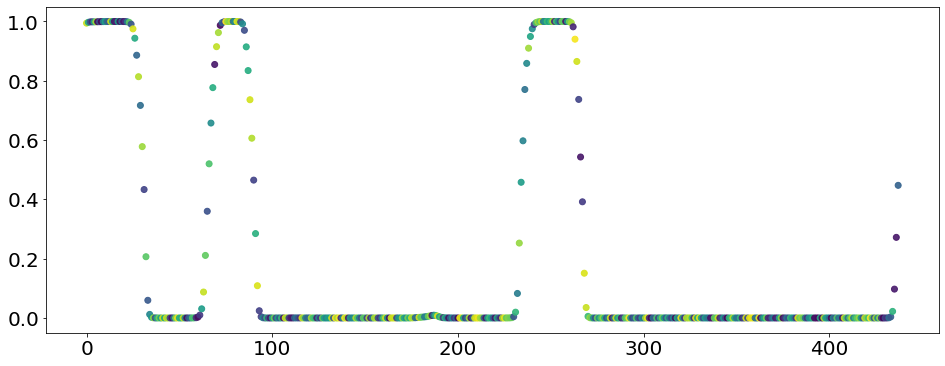

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = list(range(len(pred)))
plt.figure(figsize=(16, 6))
# font size
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# random colors
colors = np.random.rand(len(pred))

# plt.scatter(x, pred, c=colors, alpha=0.5)
plt.scatter(x, pred, c=colors, alpha=0.9)

fig_name = unp_acc
# fig_name = '1fs1_d_P63208'
plt.savefig(f'{fig_name}-{paramH.model_name}.png')
plt.show()

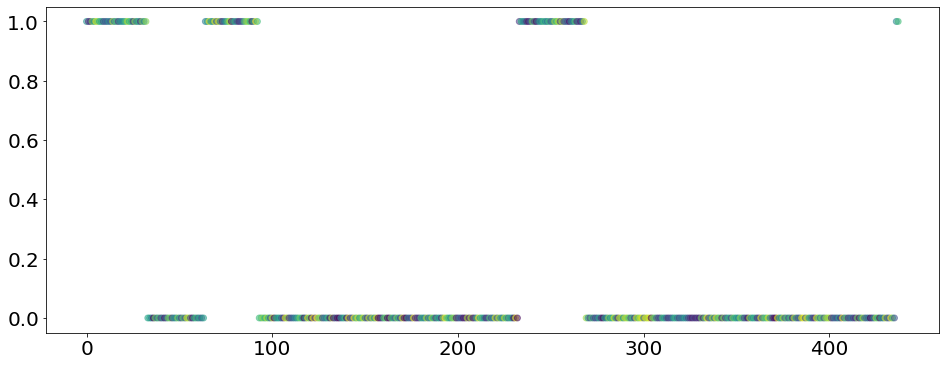

In [16]:
plt.figure(figsize=(16, 6))

# font size
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# random colors
colors = np.random.rand(len(pred))

threshold = 0.1
pred_label = [1 if i>threshold else 0 for i in pred]
plt.scatter(x, pred_label, c=colors, alpha=0.5)

# fig_name = unp_acc
# plt.savefig(f'{fig_name}.png')
plt.show()

# get index

In [17]:
def get_linkerIdx(pred_label):
    return [i for i, e in enumerate(pred_label) if e == 1]

In [18]:
get_linkerIdx(pred_label)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 436,
 437]